# Future Selection Notebook

# Feature Selection

This notebook focuses on selecting the most relevant features influencing hotel booking cancellation.
The dataset used is the output of the feature engineering stage.
Multiple feature selection techniques are applied to ensure robustness and interpretability.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [21]:
df = pd.read_pickle(r'F:\Project-DA\processed data\hotel_bookings_final.pkl')
print(df.head())
print(df.shape)

   is_canceled  lead_time  arrival_date_year  arrival_date_month  \
0            0   2.869220          -1.764073           -0.085018   
1            0   2.869220          -1.764073           -0.085018   
2            0  -0.872600          -1.764073           -0.085018   
3            0  -0.799707          -1.764073           -0.085018   
4            0  -0.787558          -1.764073           -0.085018   

   arrival_date_week_number  arrival_date_day_of_month  \
0                  0.011865                  -1.676896   
1                  0.011865                  -1.676896   
2                  0.011865                  -1.676896   
3                  0.011865                  -1.676896   
4                  0.011865                  -1.676896   

   stays_in_weekend_nights  stays_in_week_nights    adults  children  ...  \
0                -0.974216             -1.287092  0.245683 -0.304662  ...   
1                -0.974216             -1.287092  0.245683 -0.304662  ...   
2          

In [22]:
df.shape

(87389, 70)

In [24]:
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

In [25]:
X_num = X.select_dtypes(include=["int64", "float64"])
X_num.shape


(87389, 26)

In [26]:
X.shape, y.shape


((87389, 69), (87389,))

In [27]:
corr = X_num.corrwith(y).sort_values(ascending=False)


In [28]:
corr.head(10)


lead_time               0.187953
lead_to_stay_ratio      0.155323
adr                     0.134782
has_agent_flag          0.132719
total_guests            0.104613
adr_per_person          0.093361
adults                  0.090560
arrival_date_year       0.088021
total_stay_nights       0.084643
stays_in_week_nights    0.083610
dtype: float64

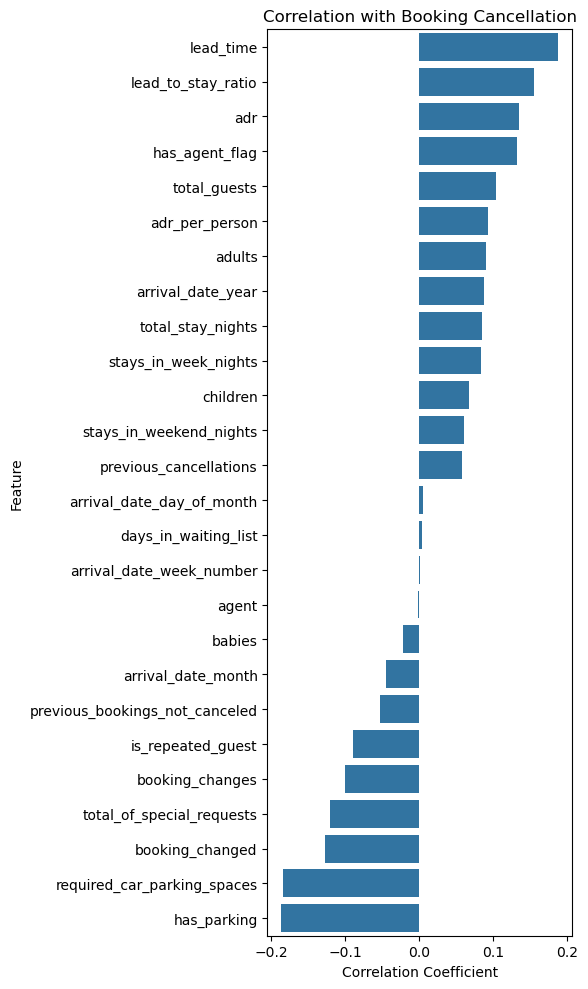

In [29]:
plt.figure(figsize=(6,10))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation with Booking Cancellation")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Correlation Insights

Lead time, previous cancellations, and deposit-related features
show strong correlation with booking cancellation.
This step provides an initial statistical intuition about feature relevance.


In [30]:
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_num, y)

anova_features = X_num.columns[selector.get_support()]
anova_features


Index(['lead_time', 'booking_changes', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_guests', 'lead_to_stay_ratio',
       'booking_changed', 'has_parking', 'has_agent_flag'],
      dtype='object')